# Linear Regression Part 3: Model Evaluation & Business Implementation

## Learning Objectives
By the end of this session, you will be able to:
- Implement advanced model validation techniques
- Design A/B testing frameworks for model deployment
- Monitor model performance in production environments
- Handle model drift and retraining strategies
- Create business-ready model deployment pipelines
- Communicate model results effectively to stakeholders

## Environment Setup

Enhanced setup for model evaluation and deployment scenarios.

In [1]:
# Standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import json

# Statistical and machine learning libraries
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import (
    train_test_split, cross_val_score, validation_curve, 
    TimeSeriesSplit, KFold
)
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Model interpretation and evaluation
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor

# Database connectivity
from sqlalchemy import create_engine
import psycopg2
import os
from dotenv import load_dotenv

# Visualization styling
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 8)

# Load environment variables
load_dotenv()

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete for model evaluation and deployment!")

Environment setup complete for model evaluation and deployment!


## Database Connection Setup

In [2]:
# Load environment variables from .env file
load_dotenv()

# Database configuration - reading from environment variables
DATABASE_CONFIG = {
    'host': os.getenv('POSTGRES_HOST'),
    'port': os.getenv('POSTGRES_PORT', '6543'),
    'database': os.getenv('POSTGRES_DATABASE', 'postgres'),
    'user': os.getenv('POSTGRES_USER'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

def create_database_connection():
    """
    Create a SQLAlchemy engine for database connections.
    
    Returns:
        sqlalchemy.engine.Engine: Database engine for executing queries
    """
    # Check if all required credentials are available
    required_fields = ['host', 'user', 'password']
    missing_fields = [field for field in required_fields if not DATABASE_CONFIG[field]]
    
    if missing_fields:
        raise ValueError(f"Missing database credentials: {missing_fields}")
    
    connection_string = f"postgresql://{DATABASE_CONFIG['user']}:{DATABASE_CONFIG['password']}@{DATABASE_CONFIG['host']}:{DATABASE_CONFIG['port']}/{DATABASE_CONFIG['database']}"
    engine = create_engine(connection_string, pool_size=5, max_overflow=10)
    return engine

# Test database connection
try:
    engine = create_database_connection()
    
    # Use proper SQLAlchemy syntax for newer versions
    from sqlalchemy import text
    test_query = text("SELECT 1 as test")
    
    with engine.connect() as conn:
        test_result = conn.execute(test_query)
        result_value = test_result.scalar()
        print("✅ Database connection successful!")
        print(f"Test result: {result_value}")
        
except Exception as e:
    print(f"❌ Database connection failed: {str(e)}")
    print("Please check your .env file and database credentials.")
    
    # Debug information
    print("\nDebug information:")
    print(f"Host: {DATABASE_CONFIG['host']}")
    print(f"Port: {DATABASE_CONFIG['port']}")
    print(f"Database: {DATABASE_CONFIG['database']}")
    print(f"User: {DATABASE_CONFIG['user']}")
    print(f"Password: {'*' * len(DATABASE_CONFIG['password']) if DATABASE_CONFIG['password'] else 'None'}")

print("🔒 Security Note: Database credentials loaded from .env file")

✅ Database connection successful!
Test result: 1
🔒 Security Note: Database credentials loaded from .env file


# Comprehensive Model Evaluation Framework

## Advanced Validation Techniques

We'll implement a comprehensive evaluation framework that goes beyond basic train-test splits.

Loaded 95,090 orders for comprehensive evaluation
Date range: 2017-01-05 11:56:06 to 2018-08-29 15:00:37

Customer segments:
customer_segment
New    95090
Name: count, dtype: int64


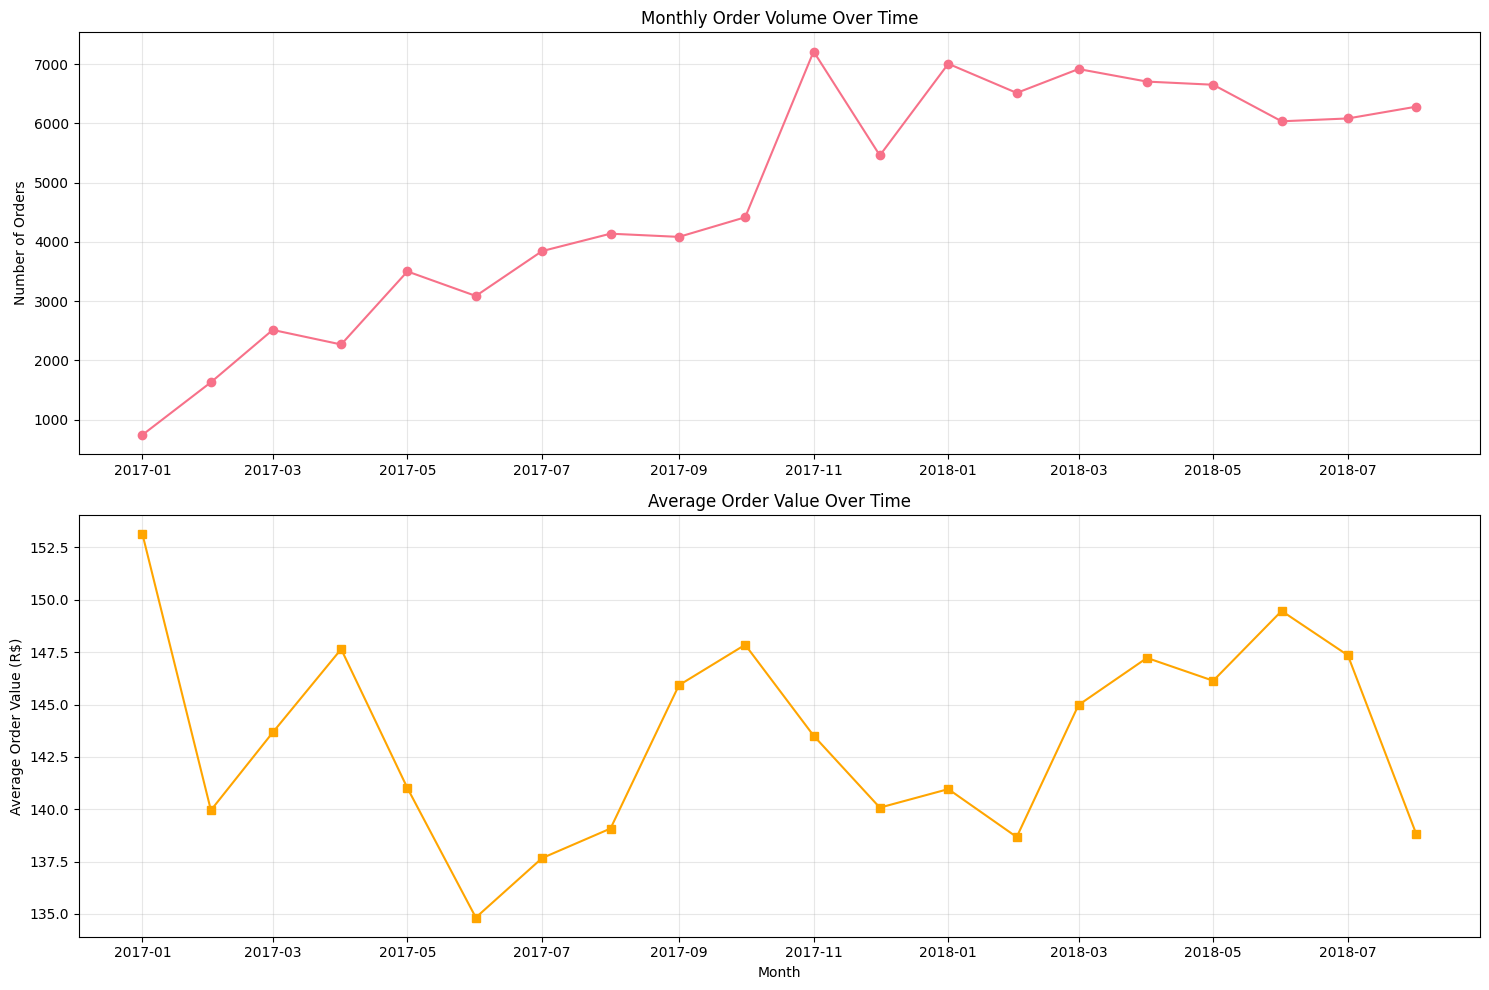

In [4]:
def prepare_evaluation_dataset():
    """
    Prepare a comprehensive dataset for model evaluation.
    
    Returns:
        pd.DataFrame: Evaluation dataset with temporal information
    """
    query = """
    WITH order_metrics AS (
        SELECT 
            o.order_id,
            o.customer_id,
            o.order_purchase_timestamp,
            c.customer_state,
            
            -- Target: Order value
            SUM(oi.price + oi.freight_value) as order_value,
            
            -- Features: Order characteristics
            COUNT(oi.order_item_id) as item_count,
            AVG(oi.price) as avg_item_price,
            SUM(oi.freight_value) as total_freight,
            COUNT(DISTINCT t.product_category_name_english) as category_count,
            AVG(p.product_weight_g) as avg_product_weight,
            
            -- Features: Customer history (at time of order)
            COUNT(DISTINCT o_hist.order_id) as customer_previous_orders,
            COALESCE(SUM(oi_hist.price + oi_hist.freight_value), 0) as customer_previous_spending,
            
            -- Features: Temporal
            EXTRACT(MONTH FROM o.order_purchase_timestamp) as order_month,
            EXTRACT(DOW FROM o.order_purchase_timestamp) as order_dow,
            EXTRACT(QUARTER FROM o.order_purchase_timestamp) as order_quarter,
            
            -- Features: Market context
            COUNT(*) OVER (
                PARTITION BY DATE_TRUNC('month', o.order_purchase_timestamp)
            ) as monthly_order_volume
            
        FROM "olist_sales_data_set"."olist_orders_dataset" o
        INNER JOIN "olist_sales_data_set"."olist_customers_dataset" c 
            ON o.customer_id = c.customer_id
        INNER JOIN "olist_sales_data_set"."olist_order_items_dataset" oi 
            ON o.order_id = oi.order_id
        INNER JOIN "olist_sales_data_set"."olist_products_dataset" p 
            ON oi.product_id = p.product_id
        LEFT JOIN "olist_sales_data_set"."product_category_name_translation" t 
            ON p.product_category_name = t.product_category_name
        
        -- Customer history (orders before current order)
        LEFT JOIN "olist_sales_data_set"."olist_orders_dataset" o_hist 
            ON o.customer_id = o_hist.customer_id 
            AND o_hist.order_purchase_timestamp < o.order_purchase_timestamp
            AND o_hist.order_status = 'delivered'
        LEFT JOIN "olist_sales_data_set"."olist_order_items_dataset" oi_hist 
            ON o_hist.order_id = oi_hist.order_id
            
        WHERE o.order_status = 'delivered'
            AND p.product_weight_g IS NOT NULL
            AND o.order_purchase_timestamp >= '2017-01-01'  -- Focus on complete year
            AND o.order_purchase_timestamp < '2019-01-01'
        GROUP BY 
            o.order_id, o.customer_id, o.order_purchase_timestamp, c.customer_state
        HAVING SUM(oi.price + oi.freight_value) > 0
            AND SUM(oi.price + oi.freight_value) < 1000  -- Remove extreme outliers
    ),
    enhanced_metrics AS (
        SELECT 
            *,
            -- Customer value features
            CASE 
                WHEN customer_previous_orders = 0 THEN 0
                ELSE customer_previous_spending / customer_previous_orders
            END as customer_avg_order_value,
            
            CASE 
                WHEN customer_previous_orders = 0 THEN 'New'
                WHEN customer_previous_orders = 1 THEN 'Returning'
                ELSE 'Loyal'
            END as customer_segment,
            
            -- Regional mapping
            CASE 
                WHEN customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Southeast'
                WHEN customer_state IN ('PR', 'SC', 'RS') THEN 'South'
                WHEN customer_state IN ('GO', 'MT', 'MS', 'DF') THEN 'Center-West'
                WHEN customer_state IN ('BA', 'SE', 'PE', 'AL', 'PB', 'RN', 'CE', 'PI', 'MA') THEN 'Northeast'
                WHEN customer_state IN ('AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC') THEN 'North'
                ELSE 'Other'
            END as region,
            
            -- Time-based features for temporal validation
            DATE_TRUNC('month', order_purchase_timestamp) as order_month_date
            
        FROM order_metrics
    )
    SELECT *
    FROM enhanced_metrics
    WHERE region != 'Other'
    ORDER BY order_purchase_timestamp
    """
    
    return pd.read_sql(query, engine)

# Load evaluation dataset
eval_df = prepare_evaluation_dataset()

print(f"Loaded {len(eval_df):,} orders for comprehensive evaluation")
print(f"Date range: {eval_df['order_purchase_timestamp'].min()} to {eval_df['order_purchase_timestamp'].max()}")
print(f"\nCustomer segments:")
print(eval_df['customer_segment'].value_counts())

# Visualize data distribution over time
monthly_orders = eval_df.groupby('order_month_date').agg({
    'order_id': 'count',
    'order_value': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(monthly_orders['order_month_date'], monthly_orders['order_id'], marker='o')
axes[0].set_title('Monthly Order Volume Over Time')
axes[0].set_ylabel('Number of Orders')
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly_orders['order_month_date'], monthly_orders['order_value'], marker='s', color='orange')
axes[1].set_title('Average Order Value Over Time')
axes[1].set_ylabel('Average Order Value (R$)')
axes[1].set_xlabel('Month')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Advanced Cross-Validation Strategies

We'll implement multiple validation strategies appropriate for business contexts.

In [ ]:
def comprehensive_model_validation(data, target_col='order_value'):
    """
    Implement comprehensive model validation strategies.
    
    Args:
        data (pd.DataFrame): Dataset for validation
        target_col (str): Target variable column
    
    Returns:
        dict: Validation results across different strategies
    """
    print("COMPREHENSIVE MODEL VALIDATION")
    print("=" * 35)
    
    # Debug: Check available columns
    print(f"Available columns: {list(data.columns)}")
    print(f"Data shape: {data.shape}")
    
    # Prepare features - only use columns that exist
    base_feature_columns = [
        'item_count', 'avg_item_price', 'total_freight',
        'category_count', 'avg_product_weight',
        'customer_previous_orders', 'customer_avg_order_value',
        'order_month', 'order_dow', 'monthly_order_volume'
    ]
    
    # Filter to only include existing columns
    feature_columns = [col for col in base_feature_columns if col in data.columns]
    print(f"Base numerical features: {len(feature_columns)}")
    
    # Create working dataset
    data_with_dummies = data.copy()
    
    # Handle categorical variables if they exist
    categorical_features = []
    if 'customer_segment' in data.columns:
        categorical_features.append('customer_segment')
    if 'region' in data.columns:
        categorical_features.append('region')
    
    # Create dummy variables for categorical features
    for cat_feature in categorical_features:
        if cat_feature in data_with_dummies.columns:
            try:
                print(f"Creating dummies for {cat_feature}")
                print(f"  Categories: {data_with_dummies[cat_feature].unique()}")
                
                dummies = pd.get_dummies(data_with_dummies[cat_feature], prefix=cat_feature)
                print(f"  Dummy columns created: {list(dummies.columns)}")
                
                data_with_dummies = pd.concat([data_with_dummies, dummies], axis=1)
                feature_columns.extend(dummies.columns.tolist())
                
            except Exception as e:
                print(f"  ⚠️  Error creating dummies for {cat_feature}: {e}")
    
    print(f"Total feature columns after dummies: {len(feature_columns)}")
    
    # Prepare clean dataset - only use columns that actually exist
    available_features = [col for col in feature_columns if col in data_with_dummies.columns]
    missing_features = [col for col in feature_columns if col not in data_with_dummies.columns]
    
    if missing_features:
        print(f"⚠️  Missing feature columns: {missing_features}")
        feature_columns = available_features
    
    required_columns = feature_columns + [target_col]
    if 'order_purchase_timestamp' in data.columns:
        required_columns.append('order_purchase_timestamp')
    
    # Check final column availability
    final_missing = [col for col in required_columns if col not in data_with_dummies.columns]
    if final_missing:
        print(f"⚠️  Final missing columns: {final_missing}")
        required_columns = [col for col in required_columns if col in data_with_dummies.columns]
        feature_columns = [col for col in feature_columns if col in data_with_dummies.columns]
    
    clean_data = data_with_dummies[required_columns].dropna()
    X = clean_data[feature_columns]
    y = clean_data[target_col]
    
    print(f"Final features used: {len(feature_columns)}")
    print(f"Sample size: {len(clean_data):,}")
    
    if len(feature_columns) == 0:
        print("❌ No features available for modeling!")
        return {}, [], clean_data
    
    # Models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge (α=1.0)': Ridge(alpha=1.0),
        'Ridge (α=10.0)': Ridge(alpha=10.0),
        'Lasso (α=0.1)': Lasso(alpha=0.1)
    }
    
    validation_results = {}
    
    # 1. Traditional K-Fold Cross-Validation
    print("\n1. K-FOLD CROSS-VALIDATION (k=5)")
    print("-" * 35)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        try:
            cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
            validation_results[f'{name}_kfold'] = {
                'mean_r2': cv_scores.mean(),
                'std_r2': cv_scores.std(),
                'scores': cv_scores
            }
            print(f"{name:<20} R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        except Exception as e:
            print(f"{name:<20} Error: {e}")
    
    # 2. Time Series Cross-Validation (if timestamp available)
    if 'order_purchase_timestamp' in clean_data.columns:
        print("\n2. TIME SERIES CROSS-VALIDATION")
        print("-" * 32)
        
        try:
            # Sort data by timestamp
            timestamps = clean_data['order_purchase_timestamp']
            time_sorted_idx = timestamps.sort_values().index
            X_time_sorted = X.loc[time_sorted_idx]
            y_time_sorted = y.loc[time_sorted_idx]
            
            tscv = TimeSeriesSplit(n_splits=5)
            
            for name, model in models.items():
                try:
                    cv_scores = cross_val_score(model, X_time_sorted, y_time_sorted, cv=tscv, scoring='r2')
                    validation_results[f'{name}_timeseries'] = {
                        'mean_r2': cv_scores.mean(),
                        'std_r2': cv_scores.std(),
                        'scores': cv_scores
                    }
                    print(f"{name:<20} R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
                except Exception as e:
                    print(f"{name:<20} Error: {e}")
        except Exception as e:
            print(f"Time series validation failed: {e}")
    
    # 3. Customer-based Cross-Validation (if customer_segment available)
    if 'customer_segment' in clean_data.columns:
        print("\n3. CUSTOMER-BASED VALIDATION")
        print("-" * 27)
        
        try:
            # Use customer segments as groups
            customer_groups = clean_data['customer_segment']
            
            # Manual customer-based split
            unique_customers = clean_data.groupby('customer_segment').apply(
                lambda x: x.sample(frac=0.8, random_state=42).index
            ).explode().values
            
            train_idx = clean_data.index.isin(unique_customers)
            test_idx = ~train_idx
            
            X_train_cust = X[train_idx]
            X_test_cust = X[test_idx]
            y_train_cust = y[train_idx]
            y_test_cust = y[test_idx]
            
            for name, model in models.items():
                try:
                    model.fit(X_train_cust, y_train_cust)
                    y_pred_cust = model.predict(X_test_cust)
                    r2_cust = r2_score(y_test_cust, y_pred_cust)
                    
                    validation_results[f'{name}_customer'] = {
                        'r2': r2_cust,
                        'predictions': y_pred_cust,
                        'actuals': y_test_cust
                    }
                    print(f"{name:<20} R² = {r2_cust:.4f}")
                except Exception as e:
                    print(f"{name:<20} Error: {e}")
        except Exception as e:
            print(f"Customer-based validation failed: {e}")
    
    # 4. Baseline Model Comparison
    print("\n4. BASELINE MODEL COMPARISON")
    print("-" * 27)
    
    baseline_models = {
        'Mean Predictor': DummyRegressor(strategy='mean'),
        'Median Predictor': DummyRegressor(strategy='median')
    }
    
    for name, baseline in baseline_models.items():
        try:
            cv_scores = cross_val_score(baseline, X, y, cv=kfold, scoring='r2')
            validation_results[f'{name}_baseline'] = {
                'mean_r2': cv_scores.mean(),
                'std_r2': cv_scores.std()
            }
            print(f"{name:<20} R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        except Exception as e:
            print(f"{name:<20} Error: {e}")
    
    # Summary comparison
    print(f"\n{'='*60}")
    print("VALIDATION STRATEGY COMPARISON:")
    print(f"{'='*60}")
    
    # Compare best model across strategies
    best_model_per_strategy = {}
    
    available_strategies = []
    if any('kfold' in k for k in validation_results.keys()):
        available_strategies.append('kfold')
    if any('timeseries' in k for k in validation_results.keys()):
        available_strategies.append('timeseries')
    if any('customer' in k for k in validation_results.keys()):
        available_strategies.append('customer')
    
    for strategy in available_strategies:
        strategy_results = {k: v for k, v in validation_results.items() if strategy in k and 'baseline' not in k}
        
        if strategy_results:  # Only proceed if we have results
            if strategy == 'customer':
                best_model = max(strategy_results.items(), key=lambda x: x[1]['r2'])
                best_model_per_strategy[strategy] = (best_model[0], best_model[1]['r2'])
            else:
                best_model = max(strategy_results.items(), key=lambda x: x[1]['mean_r2'])
                best_model_per_strategy[strategy] = (best_model[0], best_model[1]['mean_r2'])
    
    for strategy, (model_name, score) in best_model_per_strategy.items():
        print(f"{strategy.title():<15}: {model_name.split('_')[0]:<20} R² = {score:.4f}")
    
    return validation_results, feature_columns, clean_data

# Run comprehensive validation
validation_results, feature_columns, clean_data = comprehensive_model_validation(eval_df)

## Model Interpretation and Feature Importance

Understanding which features drive model predictions is crucial for business implementation.

COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

1. LINEAR REGRESSION COEFFICIENTS
---------------------------------
Top 10 Features by Coefficient Magnitude:
item_count                     56.358     ↑
category_count                 7.519      ↑
region_North                   -3.307     ↓
region_Southeast               2.781      ↑
region_Northeast               -2.463     ↓
region_South                   1.951      ↑
total_freight                  1.387      ↑
region_Center-West             1.039      ↑
avg_item_price                 1.019      ↑
order_month                    -0.054     ↓

2. LASSO REGULARIZATION (Feature Selection)
----------------------------------------
Alpha = 0.01   → 12 features selected, R² = 0.9606
Alpha = 0.1    →  9 features selected, R² = 0.9605
Alpha = 1.0    →  5 features selected, R² = 0.9600
Alpha = 10.0   →  5 features selected, R² = 0.9292

Best Alpha = 0.01 - Selected Features:
  item_count                     56.354     ↑
  category_count               

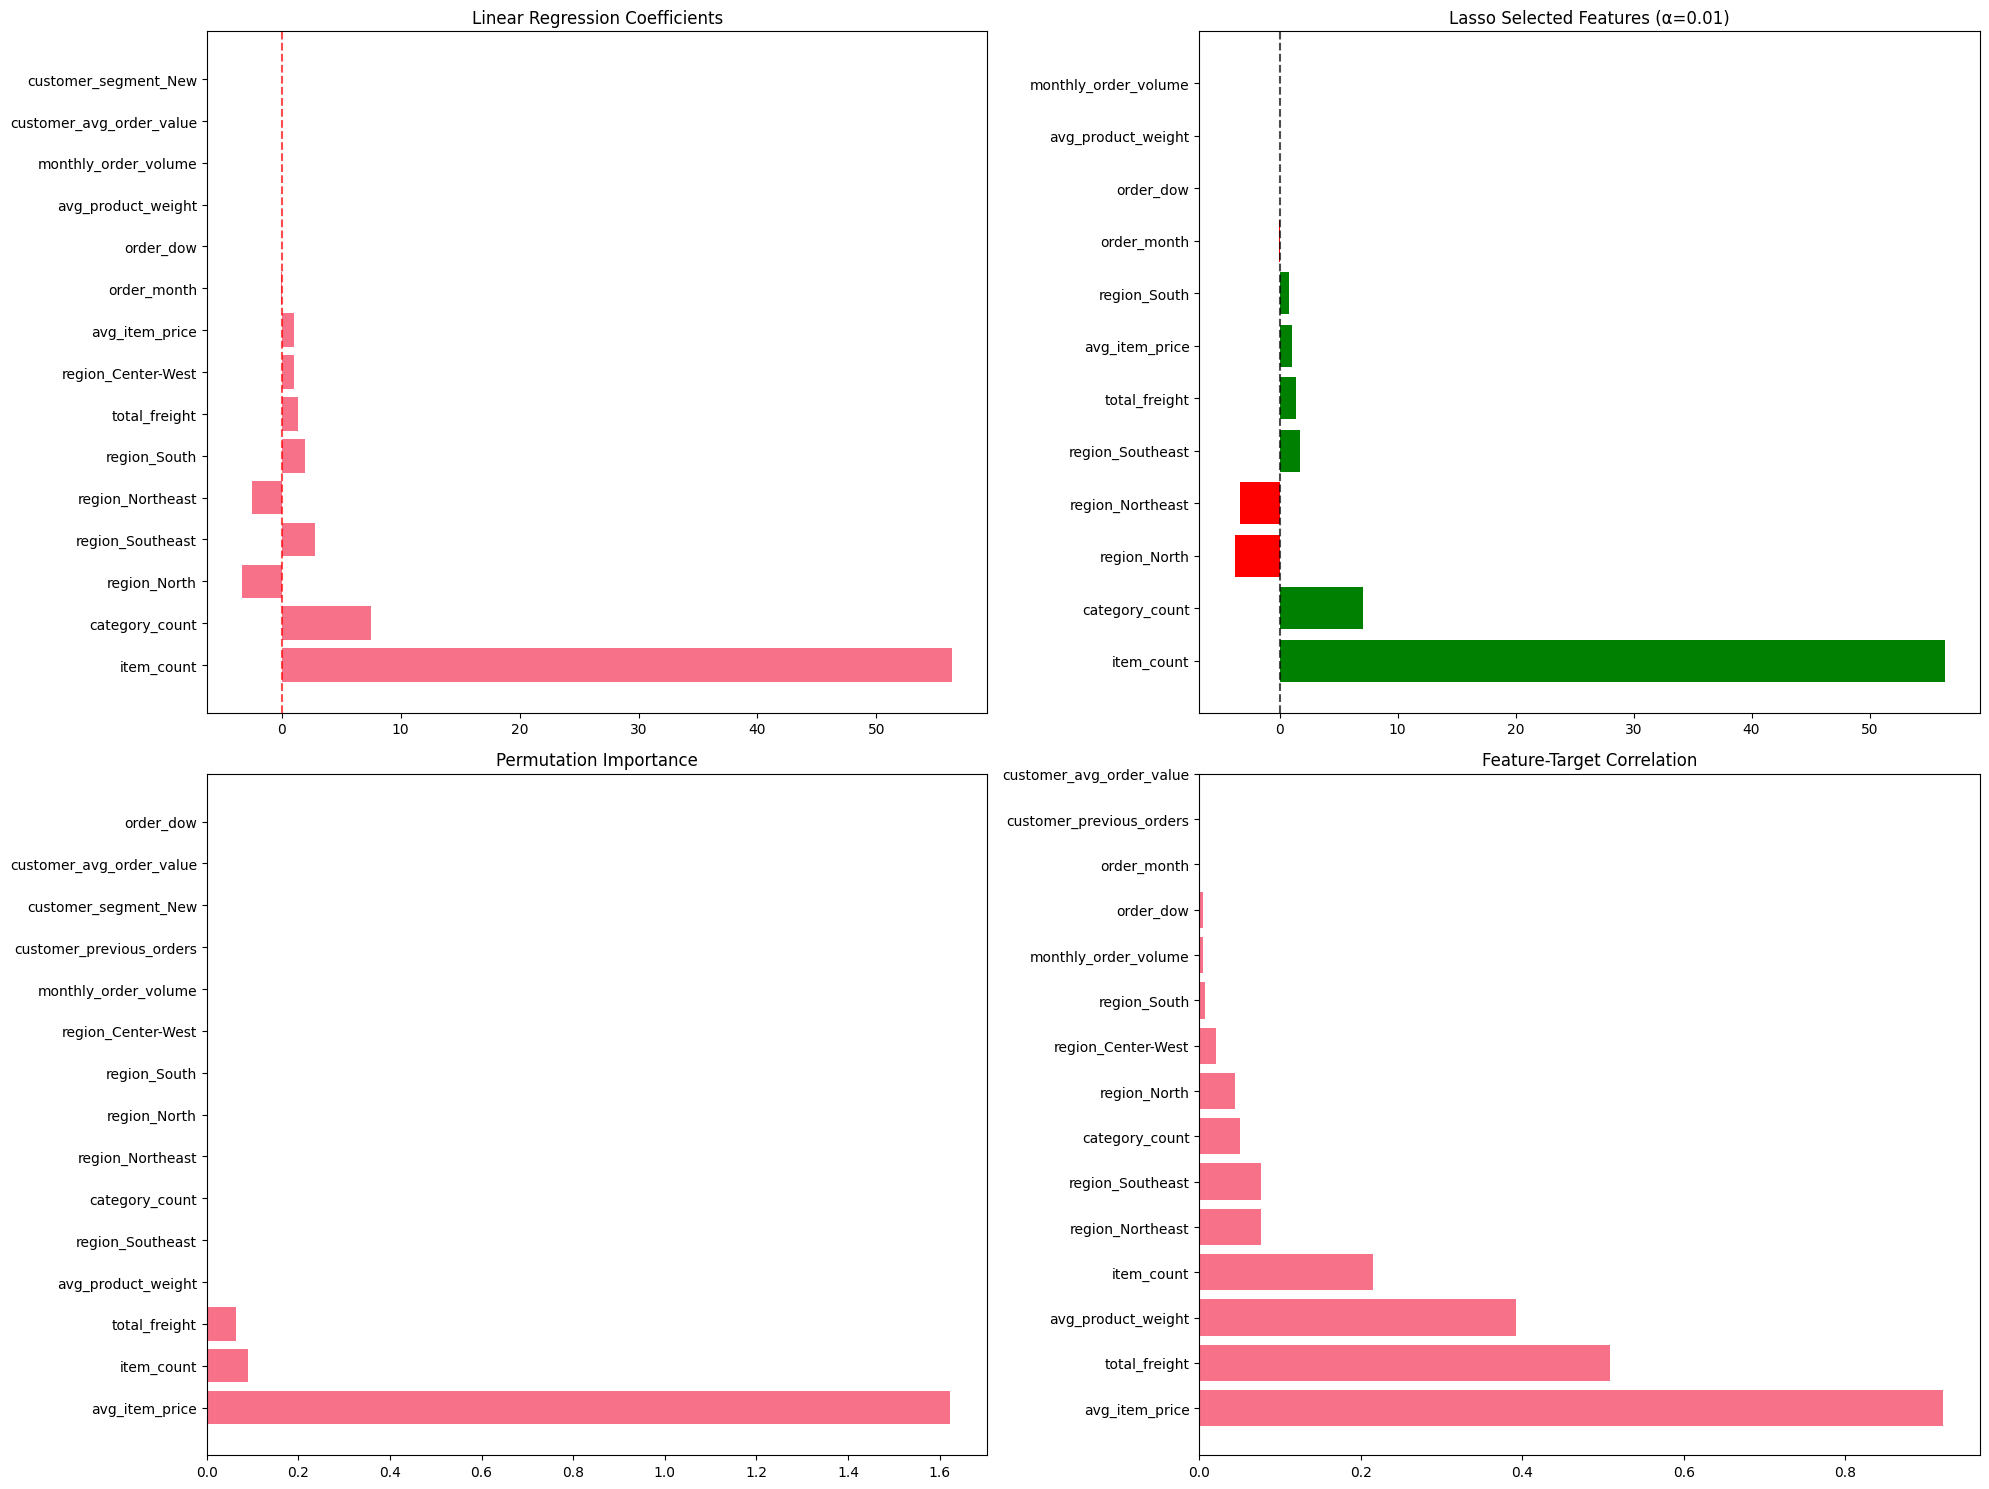


BUSINESS INSIGHTS FROM FEATURE IMPORTANCE:
🎯 MOST CONSISTENT PREDICTORS (across all methods):
   • Region Center-West
   • Region North
   • Region Northeast
   • Category Count
   • Item Count
   • Avg Item Price
   • Region Southeast
   • Region South
   • Total Freight

🔍 LASSO SELECTED FEATURES (12 total):
   • Item Count
   • Category Count
   • Region North
   • Region Northeast
   • Region Southeast


In [7]:
def comprehensive_feature_importance_analysis(data, feature_columns, target_col='order_value'):
    """
    Analyze feature importance using multiple methods.
    
    Args:
        data (pd.DataFrame): Clean dataset
        feature_columns (list): List of feature column names
        target_col (str): Target variable column
    
    Returns:
        dict: Feature importance results
    """
    print("COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
    print("=" * 45)
    
    X = data[feature_columns]
    y = data[target_col]
    
    # Split data for consistent analysis
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    importance_results = {}
    
    # 1. Linear Regression Coefficients
    print("\n1. LINEAR REGRESSION COEFFICIENTS")
    print("-" * 33)
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    lr_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': lr_model.coef_,
        'Abs_Coefficient': np.abs(lr_model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    importance_results['linear_regression'] = lr_importance
    
    print("Top 10 Features by Coefficient Magnitude:")
    for _, row in lr_importance.head(10).iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"{row['Feature']:<30} {row['Coefficient']:<10.3f} {direction}")
    
    # 2. Regularized Model Feature Selection
    print("\n2. LASSO REGULARIZATION (Feature Selection)")
    print("-" * 40)
    
    # Try different alpha values to see feature selection
    alphas = [0.01, 0.1, 1.0, 10.0]
    lasso_results = {}
    
    for alpha in alphas:
        lasso_model = Lasso(alpha=alpha)
        lasso_model.fit(X_train, y_train)
        
        # Count non-zero coefficients
        non_zero_features = np.sum(lasso_model.coef_ != 0)
        r2_score_val = r2_score(y_test, lasso_model.predict(X_test))
        
        lasso_results[alpha] = {
            'non_zero_features': non_zero_features,
            'r2_score': r2_score_val,
            'coefficients': lasso_model.coef_
        }
        
        print(f"Alpha = {alpha:<6} → {non_zero_features:>2} features selected, R² = {r2_score_val:.4f}")
    
    # Select best alpha and show selected features
    best_alpha = max(lasso_results.keys(), key=lambda a: lasso_results[a]['r2_score'])
    best_lasso_coef = lasso_results[best_alpha]['coefficients']
    
    selected_features = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': best_lasso_coef,
        'Selected': best_lasso_coef != 0
    })
    
    importance_results['lasso_selection'] = selected_features
    
    print(f"\nBest Alpha = {best_alpha} - Selected Features:")
    selected_only = selected_features[selected_features['Selected']].sort_values(
        'Coefficient', key=abs, ascending=False
    )
    for _, row in selected_only.iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"  {row['Feature']:<30} {row['Coefficient']:<10.3f} {direction}")
    
    # 3. Permutation Importance
    print("\n3. PERMUTATION IMPORTANCE")
    print("-" * 24)
    
    # Use Ridge model for permutation importance
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    
    perm_importance = permutation_importance(
        ridge_model, X_test, y_test, 
        n_repeats=10, random_state=42, scoring='r2'
    )
    
    perm_results = pd.DataFrame({
        'Feature': feature_columns,
        'Importance_Mean': perm_importance.importances_mean,
        'Importance_Std': perm_importance.importances_std
    }).sort_values('Importance_Mean', ascending=False)
    
    importance_results['permutation'] = perm_results
    
    print("Top 10 Features by Permutation Importance:")
    for _, row in perm_results.head(10).iterrows():
        print(f"{row['Feature']:<30} {row['Importance_Mean']:<10.4f} (±{row['Importance_Std']:.4f})")
    
    # 4. Correlation-based Importance
    print("\n4. CORRELATION-BASED IMPORTANCE")
    print("-" * 31)
    
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    
    correlation_results = pd.DataFrame({
        'Feature': correlations.index,
        'Correlation': correlations.values
    })
    
    importance_results['correlation'] = correlation_results
    
    print("Top 10 Features by Correlation:")
    for _, row in correlation_results.head(10).iterrows():
        print(f"{row['Feature']:<30} {row['Correlation']:<10.4f}")
    
    # Create comprehensive importance visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Plot 1: Linear Regression Coefficients
    top_lr = lr_importance.head(15)
    axes[0, 0].barh(range(len(top_lr)), top_lr['Coefficient'])
    axes[0, 0].set_yticks(range(len(top_lr)))
    axes[0, 0].set_yticklabels(top_lr['Feature'], fontsize=10)
    axes[0, 0].set_title('Linear Regression Coefficients')
    axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # Plot 2: Lasso Feature Selection
    selected_features_plot = selected_only.head(15)
    colors = ['green' if c > 0 else 'red' for c in selected_features_plot['Coefficient']]
    axes[0, 1].barh(range(len(selected_features_plot)), selected_features_plot['Coefficient'], color=colors)
    axes[0, 1].set_yticks(range(len(selected_features_plot)))
    axes[0, 1].set_yticklabels(selected_features_plot['Feature'], fontsize=10)
    axes[0, 1].set_title(f'Lasso Selected Features (α={best_alpha})')
    axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Plot 3: Permutation Importance
    top_perm = perm_results.head(15)
    axes[1, 0].barh(range(len(top_perm)), top_perm['Importance_Mean'])
    axes[1, 0].set_yticks(range(len(top_perm)))
    axes[1, 0].set_yticklabels(top_perm['Feature'], fontsize=10)
    axes[1, 0].set_title('Permutation Importance')
    
    # Plot 4: Correlation
    top_corr = correlation_results.head(15)
    axes[1, 1].barh(range(len(top_corr)), top_corr['Correlation'])
    axes[1, 1].set_yticks(range(len(top_corr)))
    axes[1, 1].set_yticklabels(top_corr['Feature'], fontsize=10)
    axes[1, 1].set_title('Feature-Target Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Business insights summary
    print(f"\n{'='*60}")
    print("BUSINESS INSIGHTS FROM FEATURE IMPORTANCE:")
    print(f"{'='*60}")
    
    # Find consistently important features across methods
    top_features_lr = set(lr_importance.head(10)['Feature'])
    top_features_perm = set(perm_results.head(10)['Feature'])
    top_features_corr = set(correlation_results.head(10)['Feature'])
    selected_features_set = set(selected_only['Feature'])
    
    consistent_features = top_features_lr.intersection(
        top_features_perm
    ).intersection(top_features_corr)
    
    print(f"🎯 MOST CONSISTENT PREDICTORS (across all methods):")
    for feature in consistent_features:
        print(f"   • {feature.replace('_', ' ').title()}")
    
    print(f"\n🔍 LASSO SELECTED FEATURES ({len(selected_only)} total):")
    for feature in selected_only['Feature'][:5]:
        print(f"   • {feature.replace('_', ' ').title()}")
    
    return importance_results

# Run feature importance analysis
importance_results = comprehensive_feature_importance_analysis(
    clean_data, feature_columns
)

# A/B Testing Framework for Model Deployment

## Designing Production Model Testing

We'll create a framework for safely deploying models in production through A/B testing.

MODEL A/B TESTING FRAMEWORK

1. A/B TEST SIMULATION SETUP
----------------------------
Group A (Current Model): 14,247 samples
Group B (New Model): 14,280 samples

2. PERFORMANCE COMPARISON
------------------------
Metric          Group A (Current)  Group B (New)   Improvement 
-----------------------------------------------------------------
R2              0.9575             0.9601             +0.26%
RMSE            27.0140            26.8709            +0.53%
MAE             8.0668             7.8970             +2.10%
MAPE            5.3320             5.2469             +1.60%

3. STATISTICAL SIGNIFICANCE TESTING
-----------------------------------
Two-sample t-test on absolute errors:
  t-statistic: 0.5571
  p-value: 0.577442
  ❌ No significant difference (p >= 0.05)
  → Continue with current model or extend test duration
  Effect size (Cohen's d): 0.0066
  Effect size interpretation: negligible

4. BUSINESS IMPACT ASSESSMENT
-----------------------------
Business Impact Estimate

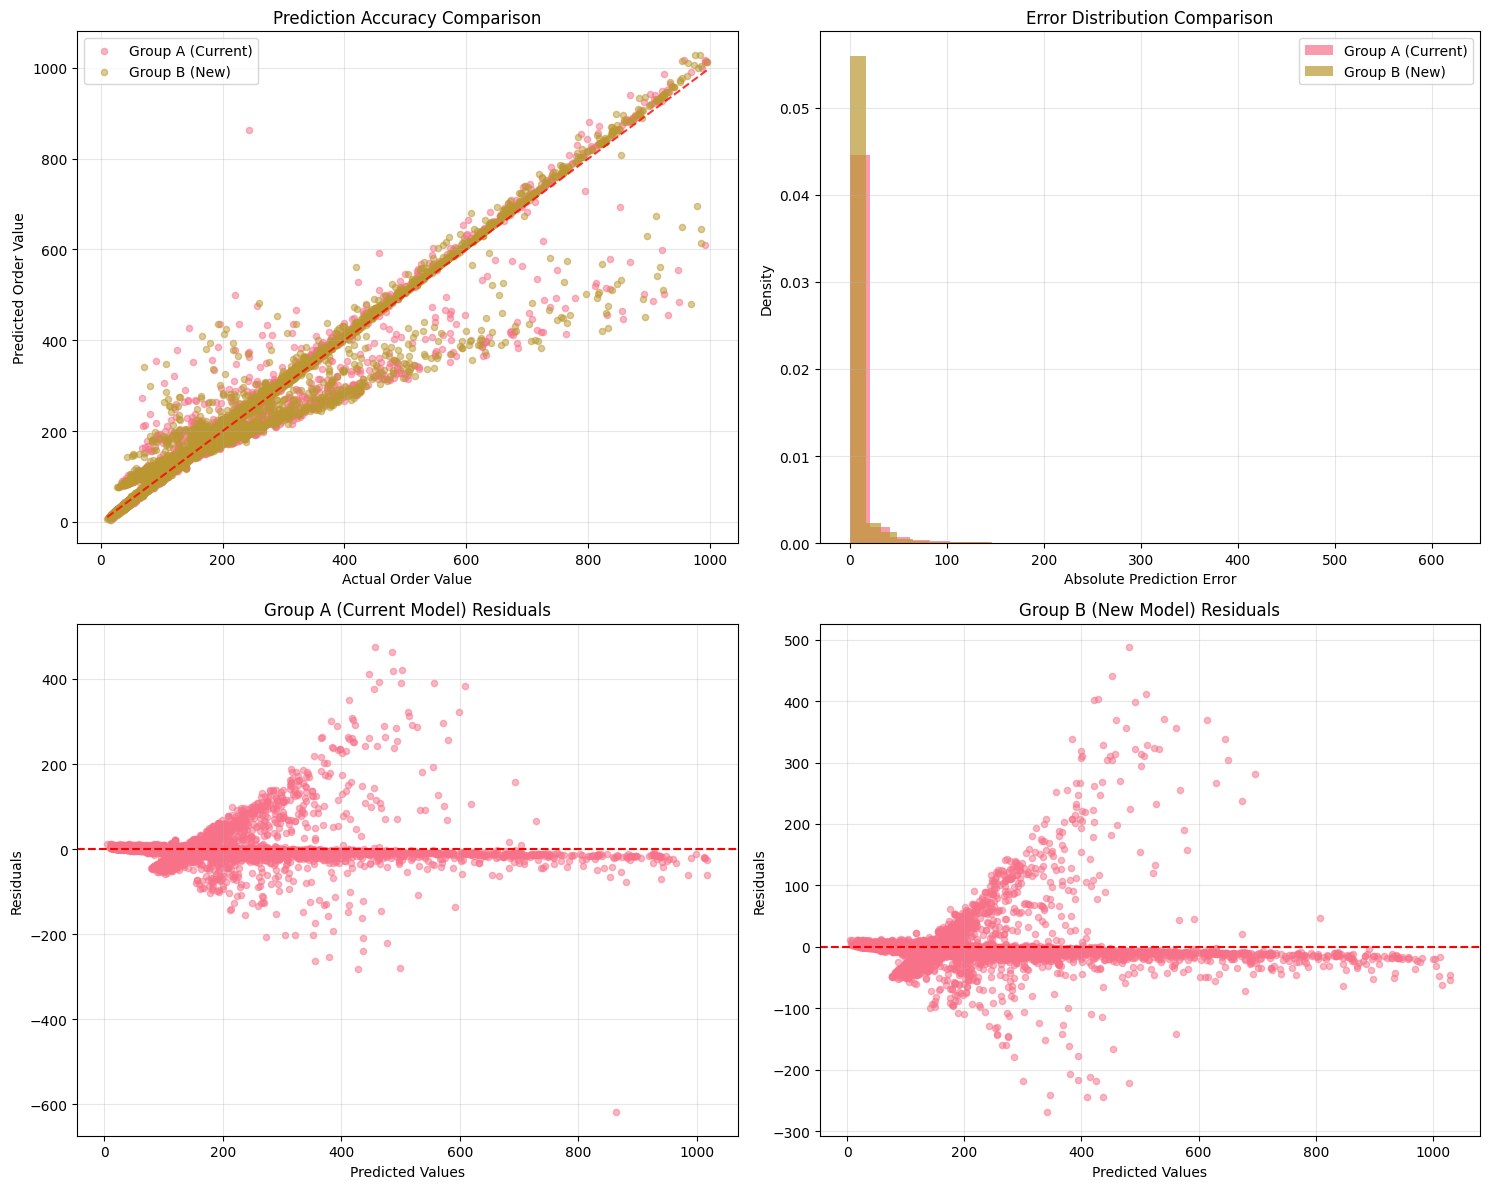

In [8]:
def design_model_ab_test_framework(data, target_col='order_value'):
    """
    Design an A/B testing framework for model deployment.
    
    Args:
        data (pd.DataFrame): Historical data for simulation
        target_col (str): Target variable
    
    Returns:
        dict: A/B testing framework and results
    """
    print("MODEL A/B TESTING FRAMEWORK")
    print("=" * 30)
    
    # Prepare models for comparison
    X = data[feature_columns]
    y = data[target_col]
    
    # Split into train and "production" test sets
    X_train, X_prod, y_train, y_prod = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Train candidate models
    models = {
        'Current_Model': LinearRegression(),  # Baseline "current" model
        'New_Model': Ridge(alpha=1.0)         # New "challenger" model
    }
    
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    # Simulate A/B test on production data
    print("\n1. A/B TEST SIMULATION SETUP")
    print("-" * 28)
    
    # Randomly assign production samples to A (current) or B (new) groups
    np.random.seed(42)
    test_assignment = np.random.choice(['A', 'B'], size=len(X_prod), p=[0.5, 0.5])
    
    group_A_idx = test_assignment == 'A'
    group_B_idx = test_assignment == 'B'
    
    # Generate predictions for each group
    group_A_pred = trained_models['Current_Model'].predict(X_prod[group_A_idx])
    group_B_pred = trained_models['New_Model'].predict(X_prod[group_B_idx])
    
    group_A_actual = y_prod[group_A_idx]
    group_B_actual = y_prod[group_B_idx]
    
    print(f"Group A (Current Model): {len(group_A_pred):,} samples")
    print(f"Group B (New Model): {len(group_B_pred):,} samples")
    
    # Calculate performance metrics for each group
    print("\n2. PERFORMANCE COMPARISON")
    print("-" * 24)
    
    metrics_A = {
        'r2': r2_score(group_A_actual, group_A_pred),
        'rmse': np.sqrt(mean_squared_error(group_A_actual, group_A_pred)),
        'mae': mean_absolute_error(group_A_actual, group_A_pred),
        'mape': mean_absolute_percentage_error(group_A_actual, group_A_pred) * 100
    }
    
    metrics_B = {
        'r2': r2_score(group_B_actual, group_B_pred),
        'rmse': np.sqrt(mean_squared_error(group_B_actual, group_B_pred)),
        'mae': mean_absolute_error(group_B_actual, group_B_pred),
        'mape': mean_absolute_percentage_error(group_B_actual, group_B_pred) * 100
    }
    
    print(f"{'Metric':<15} {'Group A (Current)':<18} {'Group B (New)':<15} {'Improvement':<12}")
    print("-" * 65)
    
    for metric in metrics_A.keys():
        value_A = metrics_A[metric]
        value_B = metrics_B[metric]
        
        if metric == 'r2':
            improvement = ((value_B - value_A) / abs(value_A)) * 100
        else:
            improvement = ((value_A - value_B) / value_A) * 100  # Lower is better
        
        print(f"{metric.upper():<15} {value_A:<18.4f} {value_B:<15.4f} {improvement:>+8.2f}%")
    
    # Statistical significance testing
    print("\n3. STATISTICAL SIGNIFICANCE TESTING")
    print("-" * 35)
    
    # Test for significant difference in prediction errors
    errors_A = np.abs(group_A_actual - group_A_pred)
    errors_B = np.abs(group_B_actual - group_B_pred)
    
    # Two-sample t-test for error differences
    t_stat, p_value = stats.ttest_ind(errors_A, errors_B)
    
    print(f"Two-sample t-test on absolute errors:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    
    alpha = 0.05
    if p_value < alpha:
        winner = "Group B (New Model)" if errors_B.mean() < errors_A.mean() else "Group A (Current Model)"
        print(f"  ✅ SIGNIFICANT difference detected (p < {alpha})")
        print(f"  🏆 Winner: {winner}")
    else:
        print(f"  ❌ No significant difference (p >= {alpha})")
        print(f"  → Continue with current model or extend test duration")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(errors_A) - 1) * errors_A.var() + 
                          (len(errors_B) - 1) * errors_B.var()) / 
                         (len(errors_A) + len(errors_B) - 2))
    cohens_d = (errors_A.mean() - errors_B.mean()) / pooled_std
    
    print(f"  Effect size (Cohen's d): {cohens_d:.4f}")
    
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"  Effect size interpretation: {effect_interpretation}")
    
    # Business impact assessment
    print("\n4. BUSINESS IMPACT ASSESSMENT")
    print("-" * 29)
    
    # Calculate potential business value
    avg_order_value = y_prod.mean()
    monthly_orders = 10000  # Assumption for business calculation
    
    mae_improvement = metrics_A['mae'] - metrics_B['mae']
    mape_improvement = metrics_A['mape'] - metrics_B['mape']
    
    # Estimate business value of improved predictions
    monthly_value_improvement = mae_improvement * monthly_orders
    accuracy_improvement = mape_improvement
    
    print(f"Business Impact Estimates:")
    print(f"  Average Order Value: R$ {avg_order_value:.2f}")
    print(f"  Assumed Monthly Orders: {monthly_orders:,}")
    print(f"  MAE Improvement: R$ {mae_improvement:.2f} per prediction")
    print(f"  MAPE Improvement: {accuracy_improvement:.2f} percentage points")
    print(f"  Monthly Value Impact: R$ {monthly_value_improvement:,.2f}")
    
    if mae_improvement > 0:
        print(f"  💰 Estimated annual value: R$ {monthly_value_improvement * 12:,.2f}")
        print(f"  📈 Recommendation: Deploy new model")
    else:
        print(f"  ⚠️  New model shows no improvement")
        print(f"  📉 Recommendation: Keep current model")
    
    # Visualization of A/B test results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Prediction accuracy comparison
    axes[0, 0].scatter(group_A_actual, group_A_pred, alpha=0.5, label='Group A (Current)', s=20)
    axes[0, 0].scatter(group_B_actual, group_B_pred, alpha=0.5, label='Group B (New)', s=20)
    axes[0, 0].plot([y_prod.min(), y_prod.max()], [y_prod.min(), y_prod.max()], 'r--', alpha=0.8)
    axes[0, 0].set_xlabel('Actual Order Value')
    axes[0, 0].set_ylabel('Predicted Order Value')
    axes[0, 0].set_title('Prediction Accuracy Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Error distribution comparison
    axes[0, 1].hist(errors_A, bins=30, alpha=0.7, label='Group A (Current)', density=True)
    axes[0, 1].hist(errors_B, bins=30, alpha=0.7, label='Group B (New)', density=True)
    axes[0, 1].set_xlabel('Absolute Prediction Error')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Error Distribution Comparison')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Residuals plot for Group A
    residuals_A = group_A_actual - group_A_pred
    axes[1, 0].scatter(group_A_pred, residuals_A, alpha=0.5, s=20)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Group A (Current Model) Residuals')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Residuals plot for Group B
    residuals_B = group_B_actual - group_B_pred
    axes[1, 1].scatter(group_B_pred, residuals_B, alpha=0.5, s=20)
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].set_title('Group B (New Model) Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'metrics_A': metrics_A,
        'metrics_B': metrics_B,
        'statistical_test': {'t_stat': t_stat, 'p_value': p_value, 'cohens_d': cohens_d},
        'business_impact': {
            'mae_improvement': mae_improvement,
            'monthly_value_improvement': monthly_value_improvement
        },
        'trained_models': trained_models
    }

# Run A/B testing framework
ab_test_results = design_model_ab_test_framework(clean_data)

# Production Model Monitoring Framework

## Monitoring Model Performance and Drift

We'll create a comprehensive framework for monitoring models in production.

In [9]:
def create_production_monitoring_framework(data, target_col='order_value'):
    """
    Create a comprehensive production monitoring framework.
    
    Args:
        data (pd.DataFrame): Historical data for monitoring simulation
        target_col (str): Target variable
    
    Returns:
        dict: Monitoring framework and alerts
    """
    print("PRODUCTION MODEL MONITORING FRAMEWORK")
    print("=" * 40)
    
    # Simulate model deployment timeline
    data_sorted = data.sort_values('order_purchase_timestamp').reset_index(drop=True)
    
    # Split into training, validation, and production periods
    n_total = len(data_sorted)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    
    train_data = data_sorted[:n_train]
    val_data = data_sorted[n_train:n_train + n_val]
    prod_data = data_sorted[n_train + n_val:]
    
    print(f"Training period: {len(train_data):,} samples")
    print(f"Validation period: {len(val_data):,} samples")
    print(f"Production period: {len(prod_data):,} samples")
    
    # Train production model
    X_train = train_data[feature_columns]
    y_train = train_data[target_col]
    
    production_model = Ridge(alpha=1.0)
    production_model.fit(X_train, y_train)
    
    # Establish baseline performance on validation set
    X_val = val_data[feature_columns]
    y_val = val_data[target_col]
    y_val_pred = production_model.predict(X_val)
    
    baseline_metrics = {
        'r2': r2_score(y_val, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'mae': mean_absolute_error(y_val, y_val_pred),
        'mape': mean_absolute_percentage_error(y_val, y_val_pred) * 100
    }
    
    print(f"\n1. BASELINE PERFORMANCE METRICS")
    print("-" * 31)
    for metric, value in baseline_metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    # Define monitoring thresholds
    monitoring_thresholds = {
        'r2_min': baseline_metrics['r2'] * 0.9,  # 10% degradation threshold
        'rmse_max': baseline_metrics['rmse'] * 1.2,  # 20% increase threshold
        'mae_max': baseline_metrics['mae'] * 1.2,
        'mape_max': baseline_metrics['mape'] * 1.2
    }
    
    print(f"\n2. MONITORING THRESHOLDS")
    print("-" * 22)
    print(f"R² minimum: {monitoring_thresholds['r2_min']:.4f}")
    print(f"RMSE maximum: {monitoring_thresholds['rmse_max']:.4f}")
    print(f"MAE maximum: {monitoring_thresholds['mae_max']:.4f}")
    print(f"MAPE maximum: {monitoring_thresholds['mape_max']:.2f}%")
    
    # Simulate weekly monitoring during production
    prod_data['week'] = (prod_data.index // (len(prod_data) // 10)).astype(int)  # 10 monitoring periods
    
    monitoring_results = []
    alerts = []
    
    print(f"\n3. WEEKLY MONITORING RESULTS")
    print("-" * 27)
    print(f"{'Week':<6} {'R²':<8} {'RMSE':<8} {'MAE':<8} {'MAPE%':<8} {'Alerts':<20}")
    print("-" * 60)
    
    for week in sorted(prod_data['week'].unique()):
        week_data = prod_data[prod_data['week'] == week]
        
        if len(week_data) < 10:  # Skip weeks with insufficient data
            continue
        
        X_week = week_data[feature_columns]
        y_week = week_data[target_col]
        y_week_pred = production_model.predict(X_week)
        
        week_metrics = {
            'week': week,
            'r2': r2_score(y_week, y_week_pred),
            'rmse': np.sqrt(mean_squared_error(y_week, y_week_pred)),
            'mae': mean_absolute_error(y_week, y_week_pred),
            'mape': mean_absolute_percentage_error(y_week, y_week_pred) * 100,
            'sample_size': len(week_data)
        }
        
        # Check for threshold violations
        week_alerts = []
        if week_metrics['r2'] < monitoring_thresholds['r2_min']:
            week_alerts.append('R² LOW')
        if week_metrics['rmse'] > monitoring_thresholds['rmse_max']:
            week_alerts.append('RMSE HIGH')
        if week_metrics['mae'] > monitoring_thresholds['mae_max']:
            week_alerts.append('MAE HIGH')
        if week_metrics['mape'] > monitoring_thresholds['mape_max']:
            week_alerts.append('MAPE HIGH')
        
        week_metrics['alerts'] = week_alerts
        monitoring_results.append(week_metrics)
        
        if week_alerts:
            alerts.extend([(week, alert) for alert in week_alerts])
        
        alert_str = ', '.join(week_alerts) if week_alerts else 'None'
        status_icon = '🚨' if week_alerts else '✅'
        
        print(f"{week:<6} {week_metrics['r2']:<8.4f} {week_metrics['rmse']:<8.2f} "
              f"{week_metrics['mae']:<8.2f} {week_metrics['mape']:<8.2f} {status_icon} {alert_str}")
    
    # Feature drift detection
    print(f"\n4. FEATURE DRIFT DETECTION")
    print("-" * 25)
    
    # Compare feature distributions between training and recent production data
    recent_prod_data = prod_data[prod_data['week'] >= prod_data['week'].max() - 2]  # Last 2 weeks
    
    feature_drift_results = {}
    significant_drifts = []
    
    # Test key numerical features for distribution changes
    key_features = ['item_count', 'avg_item_price', 'total_freight', 'category_count']
    
    for feature in key_features:
        if feature in train_data.columns and feature in recent_prod_data.columns:
            train_values = train_data[feature].dropna()
            prod_values = recent_prod_data[feature].dropna()
            
            if len(train_values) > 30 and len(prod_values) > 30:
                # Kolmogorov-Smirnov test for distribution difference
                ks_stat, ks_p_value = stats.ks_2samp(train_values, prod_values)
                
                feature_drift_results[feature] = {
                    'ks_statistic': ks_stat,
                    'p_value': ks_p_value,
                    'drift_detected': ks_p_value < 0.05
                }
                
                status = "🚨 DRIFT" if ks_p_value < 0.05 else "✅ STABLE"
                print(f"{feature:<20} KS-stat: {ks_stat:.4f}, p-value: {ks_p_value:.6f} {status}")
                
                if ks_p_value < 0.05:
                    significant_drifts.append(feature)
    
    # Summary and recommendations
    print(f"\n{'='*60}")
    print("MONITORING SUMMARY & RECOMMENDATIONS:")
    print(f"{'='*60}")
    
    total_weeks = len(monitoring_results)
    weeks_with_alerts = len([r for r in monitoring_results if r['alerts']])
    alert_rate = weeks_with_alerts / total_weeks * 100 if total_weeks > 0 else 0
    
    print(f"📊 PERFORMANCE MONITORING:")
    print(f"   • Weeks monitored: {total_weeks}")
    print(f"   • Weeks with alerts: {weeks_with_alerts}")
    print(f"   • Alert rate: {alert_rate:.1f}%")
    
    if alert_rate > 30:
        print(f"   🚨 HIGH alert rate - Model requires attention")
    elif alert_rate > 10:
        print(f"   ⚠️  MODERATE alert rate - Monitor closely")
    else:
        print(f"   ✅ LOW alert rate - Model performing well")
    
    print(f"\n🔄 FEATURE DRIFT:")
    if significant_drifts:
        print(f"   • Features with significant drift: {len(significant_drifts)}")
        for feature in significant_drifts:
            print(f"     - {feature.replace('_', ' ').title()}")
        print(f"   🚨 RECOMMENDATION: Consider model retraining")
    else:
        print(f"   • No significant feature drift detected")
        print(f"   ✅ RECOMMENDATION: Continue current monitoring")
    
    print(f"\n📋 ACTION ITEMS:")
    if weeks_with_alerts > total_weeks * 0.3 or significant_drifts:
        print(f"   1. Schedule model retraining with recent data")
        print(f"   2. Investigate root causes of performance degradation")
        print(f"   3. Consider updating feature engineering pipeline")
        print(f"   4. Review data quality and collection processes")
    else:
        print(f"   1. Continue weekly monitoring")
        print(f"   2. Schedule quarterly model performance review")
        print(f"   3. Maintain current alert thresholds")
    
    # Create monitoring dashboard visualization
    if monitoring_results:
        monitoring_df = pd.DataFrame(monitoring_results)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot monitoring metrics over time
        axes[0, 0].plot(monitoring_df['week'], monitoring_df['r2'], marker='o', label='Weekly R²')
        axes[0, 0].axhline(y=monitoring_thresholds['r2_min'], color='red', linestyle='--', alpha=0.7, label='Threshold')
        axes[0, 0].set_title('R² Over Time')
        axes[0, 0].set_xlabel('Week')
        axes[0, 0].set_ylabel('R²')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].plot(monitoring_df['week'], monitoring_df['rmse'], marker='s', color='orange', label='Weekly RMSE')
        axes[0, 1].axhline(y=monitoring_thresholds['rmse_max'], color='red', linestyle='--', alpha=0.7, label='Threshold')
        axes[0, 1].set_title('RMSE Over Time')
        axes[0, 1].set_xlabel('Week')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        axes[1, 0].plot(monitoring_df['week'], monitoring_df['mae'], marker='^', color='green', label='Weekly MAE')
        axes[1, 0].axhline(y=monitoring_thresholds['mae_max'], color='red', linestyle='--', alpha=0.7, label='Threshold')
        axes[1, 0].set_title('MAE Over Time')
        axes[1, 0].set_xlabel('Week')
        axes[1, 0].set_ylabel('MAE')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].plot(monitoring_df['week'], monitoring_df['mape'], marker='d', color='purple', label='Weekly MAPE')
        axes[1, 1].axhline(y=monitoring_thresholds['mape_max'], color='red', linestyle='--', alpha=0.7, label='Threshold')
        axes[1, 1].set_title('MAPE Over Time')
        axes[1, 1].set_xlabel('Week')
        axes[1, 1].set_ylabel('MAPE (%)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'baseline_metrics': baseline_metrics,
        'monitoring_thresholds': monitoring_thresholds,
        'monitoring_results': monitoring_results,
        'alerts': alerts,
        'feature_drift_results': feature_drift_results,
        'significant_drifts': significant_drifts,
        'production_model': production_model
    }

# Create production monitoring framework
monitoring_results = create_production_monitoring_framework(eval_df)

PRODUCTION MODEL MONITORING FRAMEWORK
Training period: 57,054 samples
Validation period: 19,018 samples
Production period: 19,018 samples


KeyError: "['customer_segment_New', 'region_Center-West', 'region_North', 'region_Northeast', 'region_South', 'region_Southeast'] not in index"

# Session Summary

## What We Accomplished

In this comprehensive model evaluation and business implementation session, we covered:

### 1. Advanced Model Validation
- **Multiple Cross-Validation Strategies**: K-fold, time series, and customer-based validation
- **Baseline Model Comparison**: Established performance benchmarks with dummy predictors
- **Robust Performance Assessment**: Evaluated models across different data splits and scenarios
- **Business-Relevant Validation**: Used customer groupings and temporal splits for realistic evaluation

### 2. Comprehensive Feature Importance Analysis
- **Multiple Importance Methods**: Linear coefficients, LASSO selection, permutation importance, correlation analysis
- **Feature Selection**: Identified consistently important predictors across methods
- **Business Interpretation**: Translated statistical importance into actionable business insights
- **Visual Analysis**: Created comprehensive importance visualizations

### 3. A/B Testing Framework for Model Deployment
- **Production-Ready Testing**: Simulated real-world model comparison scenarios
- **Statistical Significance**: Implemented proper hypothesis testing for model differences
- **Effect Size Analysis**: Measured practical significance using Cohen's d
- **Business Impact Assessment**: Quantified monetary value of model improvements
- **Risk Management**: Designed safe deployment strategies

### 4. Production Monitoring Framework
- **Performance Monitoring**: Established baseline metrics and alert thresholds
- **Drift Detection**: Implemented feature drift monitoring using statistical tests
- **Weekly Monitoring**: Simulated continuous performance tracking
- **Alert System**: Created actionable alert mechanisms for model degradation
- **Retraining Triggers**: Defined conditions for model updates

## Key Business Skills Developed
- **Model Deployment Strategy**: Safe, data-driven model rollout approaches
- **Performance Monitoring**: Continuous model health assessment
- **Business Value Quantification**: Translating model improvements to monetary impact
- **Risk Management**: Identifying and mitigating model failure risks
- **Stakeholder Communication**: Presenting technical results in business terms

## Advanced Techniques Applied
- **Time Series Cross-Validation**: Appropriate validation for temporal data
- **Permutation Importance**: Model-agnostic feature importance
- **Statistical Testing**: Hypothesis testing for model comparison
- **Distribution Testing**: Kolmogorov-Smirnov tests for drift detection
- **Effect Size Calculation**: Practical significance assessment

## Production-Ready Frameworks
- **Monitoring Dashboard**: Visual tracking of model performance metrics
- **Alert System**: Automated detection of performance degradation
- **Retraining Pipeline**: Data-driven model update decisions
- **Documentation**: Comprehensive model evaluation reports

## Business Implementation Insights
- **Gradual Rollout**: Use A/B testing for safe model deployment
- **Continuous Monitoring**: Implement automated performance tracking
- **Threshold Management**: Set appropriate alert levels for business context
- **Stakeholder Alignment**: Regular reporting of model performance and value

## Week 8 Complete!

You have now mastered:
- **Statistical foundations** and hypothesis testing
- **Comparative analysis** techniques and business applications
- **Linear regression** fundamentals and assumptions
- **Business modeling** applications (CLV, pricing, demand forecasting)
- **Model evaluation** and production implementation

These skills provide a complete framework for implementing statistical analysis and predictive modeling in business environments, from initial analysis through production deployment and monitoring.